<a href="https://colab.research.google.com/github/gitgitWi/python-lecture/blob/master/lec_20200428_Keras02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

mkdate : 2020/04/28

# Binary classification with Keras IMDB dataset




In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np, pandas as pd

`load_data`
 - `num_words = 10000` : 가장 많이 등장하는 상위 10000개 단어 선택

In [0]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels)  = imdb.load_data(num_words = 10000)

## 데이터 탐색

- train_data / test_data : 영화 review에 나오는 단어
- label : 
    - 0 : negative
    - 1 : positive

In [9]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape, 

((25000,), (25000,), (25000,), (25000,))

CNN에서는 입력 data들의 길이가 모두 같아야 하므로, 나중에 data 길이 맞춰주는 작업 필요

In [20]:
print (len(train_data[0]), len(train_data[1]))
print (train_data[0][:20])
print (train_data[1][:20])

218 189
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]
[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14]


In [16]:
print (train_labels[0])
np.bincount(train_labels)

1


array([12500, 12500])

In [0]:
word_index = imdb.get_word_index()

word_index = { k : (v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

reverse_word_index = dict([ (value, key) for (key, value) in word_index.items() ])


In [42]:
reverse_word_index.get(np.random.randint(100000), '?')

'ager'

In [0]:
def decode_review(text) : return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [36]:
print (decode_review(train_data[0]))
print (decode_review(train_data[1]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

## 데이터 준비

data는 신경망 주입 전 tensor로 변환해야 함

### Way01. `one-hot-encoding`

- 정수 배열을 0, 1로 이루어진 vector로 변환
    - ex. [3,5] ~> [1,1,0,0,0,....,0]

- 이후 실수 vecotr data 다룰수 있는 dense layer를 첫번째 layer로 사용
- 여기서 num_words * num_reviews 크기의 행렬이 필요하기 때문에 memory 를 많이 사용; 각 데이터마다 제각기 다른 행렬을 만들게 됨

### Way02. `padding`

- 정수 배열의 길이가 모두 같도록 padding 추가해 `max_length * num_reviews` 크기의 정수 tensor 
- 이후 `embedding` layer를 신경망의 첫번째 layer로 사용
- 여기서는 이 방식을 사용

```python
keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen=None, 
    dtype='int32', 
    padding='pre',          # 'pre' or 'post'
    truncating='pre',       # 'pre' or 'post' 
    value=0.0)              # padding value

  >>> sequence = [[1], [2, 3], [4, 5, 6]]
  >>> tf.keras.preprocessing.sequence.pad_sequences(sequence)
  array([[0, 0, 1],
         [0, 2, 3],
         [4, 5, 6]], dtype=int32)

  >>> tf.keras.preprocessing.sequence.pad_sequences(sequence, value=-1)
  array([[-1, -1,  1],
         [-1,  2,  3],
         [ 4,  5,  6]], dtype=int32)

  >>> tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post')
  array([[1, 0, 0],
         [2, 3, 0],
         [4, 5, 6]], dtype=int32)

  >>> tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=2)
  array([[0, 1],
         [2, 3],
         [5, 6]], dtype=int32)

```


In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value = word_index['<PAD>'],
                                                        padding = "post",
                                                        maxlen = 256
                                                        )

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value = word_index["<PAD>"],
                                                       padding = "post",
                                                       maxlen = 256
                                                       )

In [46]:
print (len (train_data[0]), len (train_data[1]), )
train_data[0]

256 256


array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

### `keras.layers.Embedding`

```python
def keras.layers.Embedding(
    input_dim, 
    output_dim, 
    embeddings_initializer='uniform', 
    embeddings_regularizer=None, 
    activity_regularizer=None, 
    embeddings_constraint=None, 
    mask_zero=False, 
    input_length=None, 
    **kwargs)
```

- 정수로 입력 받은 단어 입력 받고
- 각 단어 index에 해당하는 embedding vector 찾음
- vector는 훈련을 통해 학습, 출력 배열에 새로운 차원으로 추가됨
- 최종 차원은 (batch, sequence, embedding)

Turns positive integers (indexes) into dense vectors of fixed size.

  e.g. `[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]`

<br />

### `keras.layers.GlobalAveragePooling1D`

```python
keras.layers.GlobalAveragePooling1D(
    data_format='channels_last', 
    **kwargs
    )
```

- sequence 차원에 대해 평균 계산, 
- 각 sample에 대해 고정된 길이의 출력 vector 반환

<br />

### `keras.layers.Dense`

- `keras.layers.Dense(16, activation='relu')` : 16개 은닉 유닛 가진 fully-connected dense layer
- `keras.layers.Dense(1, activation='sigmoid')` : sigmoid 활성화 함수를 사용해 0~1 사이 실수(확률 또는 신뢰도) 출력

In [48]:
max_words = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(max_words, 16, input_shape = (None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


## Compile



In [0]:
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
    )

## Validation dataset

원본 train dataset 에서 10000개 sample 떼어내어 validation set

훈련 dataset만 사용해 model 개발하고 tuning

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Training

```python
model.fit(
    x=None, 
    y=None, 
    batch_size=None, 
    epochs=1, 

    # verbose: 0, 1, or 2. Verbosity mode.
    # 0 = silent, 1 = progress bar, 2 = one line per epoch.
    verbose=1, 
    callbacks=None, 
    validation_split=0.0, 
    validation_data=None, 
    shuffle=True, 
    class_weight=None, 
    sample_weight=None, 
    initial_epoch=0, 
    steps_per_epoch=None, 
    validation_steps=None, 
    validation_batch_size=None, 
    validation_freq=1, 
    max_queue_size=10, 
    workers=1, 
    use_multiprocessing=False, 
    **kwargs
    )
```

- at mini-batch with 512 samples
- 40 epochs 
- training 1번 할 때마다 validataion test 1번씩

In [52]:
history = model.fit(
    partial_x_train,    partial_y_train,
    epochs = 40,
    batch_size = 512,
    validation_data = (x_val, y_val),
    verbose = 1
)

Epoch 1/40
30/30 [==============================] - 1s 23ms/step - loss: 0.6920 - accuracy: 0.5722 - val_loss: 0.6905 - val_accuracy: 0.6332
Epoch 2/40
30/30 [==============================] - 1s 18ms/step - loss: 0.6878 - accuracy: 0.5993 - val_loss: 0.6846 - val_accuracy: 0.7230
Epoch 3/40
30/30 [==============================] - 1s 17ms/step - loss: 0.6780 - accuracy: 0.7345 - val_loss: 0.6722 - val_accuracy: 0.7084
Epoch 4/40
30/30 [==============================] - 1s 17ms/step - loss: 0.6607 - accuracy: 0.7541 - val_loss: 0.6519 - val_accuracy: 0.7329
Epoch 5/40
30/30 [==============================] - 1s 17ms/step - loss: 0.6338 - accuracy: 0.7637 - val_loss: 0.6226 - val_accuracy: 0.7641
Epoch 6/40
30/30 [==============================] - 1s 18ms/step - loss: 0.5970 - accuracy: 0.7979 - val_loss: 0.5858 - val_accuracy: 0.7887
Epoch 7/40
30/30 [==============================] - 1s 17ms/step - loss: 0.5544 - accuracy: 0.8183 - val_loss: 0.5444 - val_accuracy: 0.8090
Epoch 8/40
30

## Evaluate model

In [55]:
results = model.evaluate(test_data, test_labels, verbose=1)
results

782/782 [==============================] - 1s 1ms/step - loss: 0.3219 - accuracy: 0.8738


[0.32191553711891174, 0.8737599849700928]

In [0]:
??model.evaluate

## Graph of Accuracy and Loss

위에서 `history = model.fit(...)`을 통해 훈련 과정을 dictionary 형태로 저장

In [60]:
type(history)

tensorflow.python.keras.callbacks.History

In [56]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

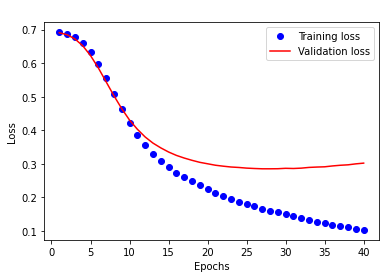

In [64]:
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and Validation Loss', fontdict={'color' : 'white'})
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

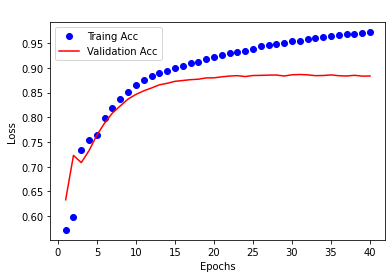

In [69]:
# clear figure
plt.clf()

plt.plot(epochs, acc, 'bo', label = 'Traing Acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation Acc')
plt.title('Training and Validation Accuracy', fontdict={'color' : 'white'})
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

위의 두 차트를 통해 epoch = 20 부근에서 overfitting 발생하는 것을 알수 있음

model compile에서 사용한 optimizer 가 매 훈련 반복할 때 마다 최적화 대상의 값을 최소화하기 때문


실무적으로는,  overfitting 구간을 찾기 위해 epoch 값을 일부러 과하게 지정함